## $\color{magenta}{\text{In this notebook, we try to determine horizontal and vertical components}}$
## $\color{magenta}{\text{of magnetic field, in order to examine differences between polar and}}$
## $\color{magenta}{\text{quiet region of the Sun.}}$

### Firstly, we import necessary packages.

In [131]:
import MilneEddington as ME
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from matplotlib.ticker import LogLocator
import pandas as pd
from tabulate import tabulate
import utils as ut
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable

### We import data derived from MILOS inversion procedure.

In [124]:
B = fits.open('north_pole_milos.fits')[1].data#[:512, :512]
gamma = fits.open('north_pole_milos.fits')[2].data#[:512, :512]
chi = fits.open('north_pole_milos.fits')[3].data#[:512, :512]
vlos = fits.open('north_pole_milos.fits')[4].data#[:512, :512]

### We need some info about the file.

In [115]:
file = fits.open('north_pole_milos.fits')
header = n[0].header
print(repr(header))

SIMPLE  =                    T / Written by IDL:  Mon Jul 26 09:47:18 2021      
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
NAXIS1  =                 2000 /                                                
NAXIS2  =                 1024 /                                                
EXTEND  =                    T / File contains extensions                       
XCEN    =             -4.64630 /                                                
YCEN    =              912.331 /                                                
XSCALE  =             0.148570 /                                                
YSCALE  =             0.159992 /                                                
TSTART  = '2007-09-25T00:10:45.432' /                                           
TEND    = '2007-09-25T07:26:31.039' /                                           
MAPID   = '45757   '        

### We plot few parameters derived from MILOS inversion procedure.

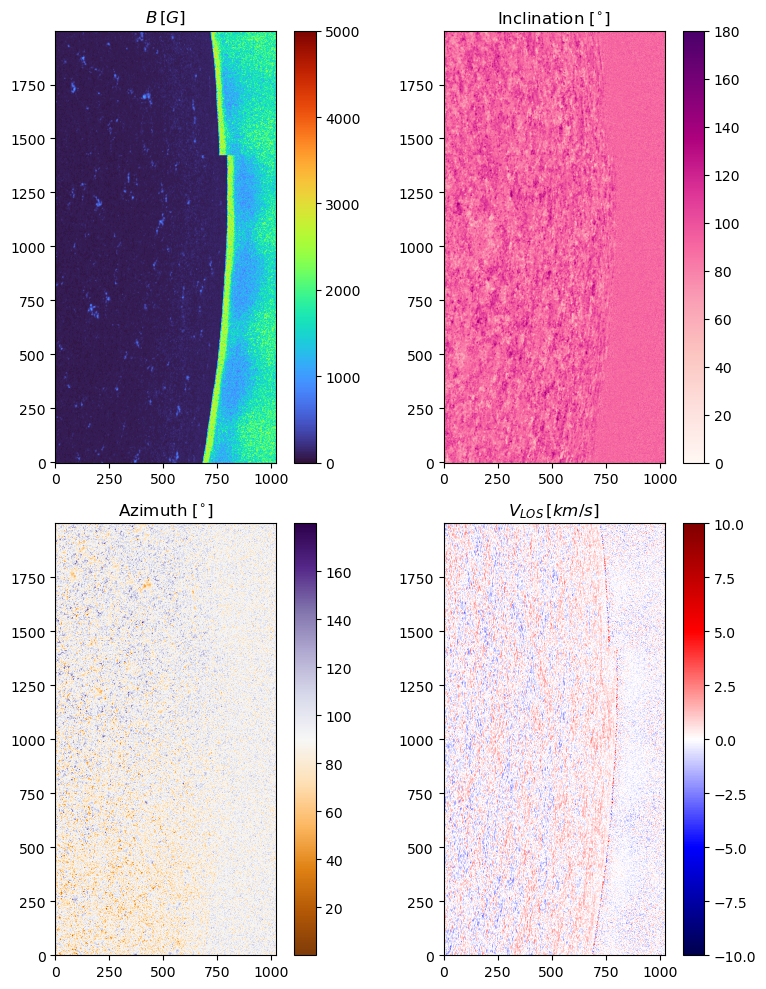

In [118]:
plt.figure(figsize=(8, 10))

plt.subplot(221)
plt.imshow(B.T, origin='lower', cmap='turbo')
plt.colorbar()
plt.title(r'$B\,[G]$')

plt.subplot(222)
plt.imshow(gamma.T, origin='lower', cmap='RdPu')
plt.colorbar()
plt.title(r'Inclination $[^{\circ}]$')

plt.subplot(223)
plt.imshow(chi.T, origin='lower', cmap='PuOr')
plt.colorbar()
plt.title(r'Azimuth $[^{\circ}]$')

plt.subplot(224)
plt.imshow(vlos.T, origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'$V_{LOS}\,[km/s]$')

plt.tight_layout()
plt.show()

### We use part of the FOV for our analysis.

In [132]:
B = fits.open('north_pole_milos.fits')[1].data[:512, :512]
gamma = fits.open('north_pole_milos.fits')[2].data[:512, :512]
chi = fits.open('north_pole_milos.fits')[3].data[:512, :512]
vlos = fits.open('north_pole_milos.fits')[4].data[:512, :512]

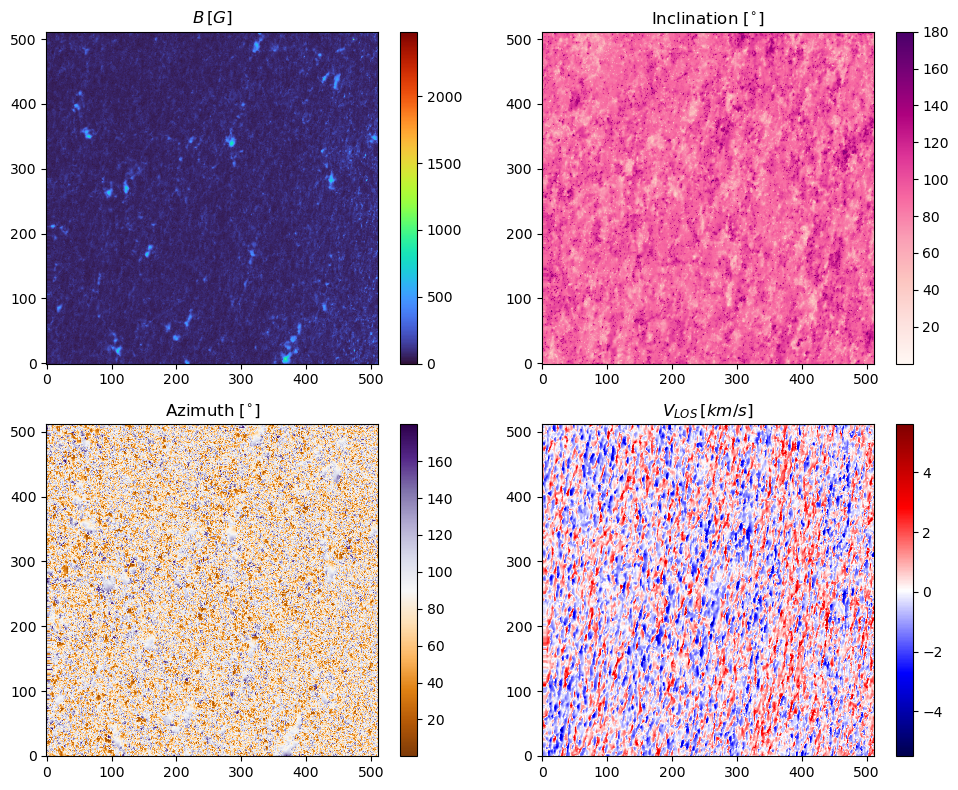

In [120]:
plt.figure(figsize=(10, 8))

plt.subplot(221)
plt.imshow(B.T, origin='lower', cmap='turbo')
plt.colorbar()
plt.title(r'$B\,[G]$')

plt.subplot(222)
plt.imshow(gamma.T, origin='lower', cmap='RdPu')
plt.colorbar()
plt.title(r'Inclination $[^{\circ}]$')

plt.subplot(223)
plt.imshow(chi.T, origin='lower', cmap='PuOr')
plt.colorbar()
plt.title(r'Azimuth $[^{\circ}]$')

plt.subplot(224)
plt.imshow(vlos.T, origin='lower', cmap='seismic')
plt.colorbar()
plt.title(r'$V_{LOS}\,[km/s]$')

plt.tight_layout()
plt.show()

### Now, from the information on observation of the polar region, we can
### get central coordinates of the observation relative to the Sun's center.
### We use $\varphi$ (heliographic longitude) and $\delta$ (heliographic latitude).

In [133]:
phi_arcsec = -4.64630  # XCEN, longitude in arcsec
delta_arcsec = 912.331  # YCEN, latitude in arcsec

# Conversion from arcseconds to degrees
phi_deg = phi_arcsec / 3600
delta_deg = delta_arcsec / 3600

# Conversion from degrees to radians
phi = np.deg2rad(phi_deg)
delta = np.deg2rad(delta_deg)

### Using basics of spherical trigonometry, we can calculate zenith angles.
### Two solutions ($i_1$ and $i_2$) are distributed with respect to the 
### local normal of the photosphere. This is due to the 180◦ ambiguity in
### the direction of the magnetic field vector projected onto the sky plane.
### Equations are:
### (1) $i_1=\arccos[\cos{\gamma}\cos{\theta} + \sin{\gamma}\sin{\theta}\cos{(\beta-\chi)}]$,
### (2) $i_2=\arccos[\cos{\gamma}\cos{\theta} + \sin{\gamma}\sin{\theta}\cos{(\pi-(\beta-\chi))}]$,
### where $\theta$ is the angle between the local normal and the LOS, and $\beta$
### is 'like' the azimuth angle of the local normal.

In [134]:
chi = np.deg2rad(chi)
gamma = np.deg2rad(gamma)

theta = np.arccos(np.cos(delta) * np.cos(phi))
beta = np.arccos(np.cos(delta) * np.sin(phi) / np.sin(theta))

###########################################################################################################

i1 = np.arccos(np.clip(np.cos(gamma) * np.cos(theta) + np.sin(gamma) * np.sin(theta) * np.cos(beta - chi), -1, 1))
i2 = np.arccos(np.clip(np.cos(gamma) * np.cos(theta) + np.sin(gamma) * np.sin(theta) * np.cos(np.pi - (beta - chi)), -1, 1))


i1 = np.degrees(i1) # conversion to degrees
i2 = np.degrees(i2) # conversion to degrees

### We can visualize the result, by plotting some density of points.
### Magnetic fields are classified as vertical to the local surface 
### if they are located either close to $0^{\circ}$ or $180^{\circ}$ (dashed lines) and 
### as horizontal if located near $90^{\circ}$ (bold lines).

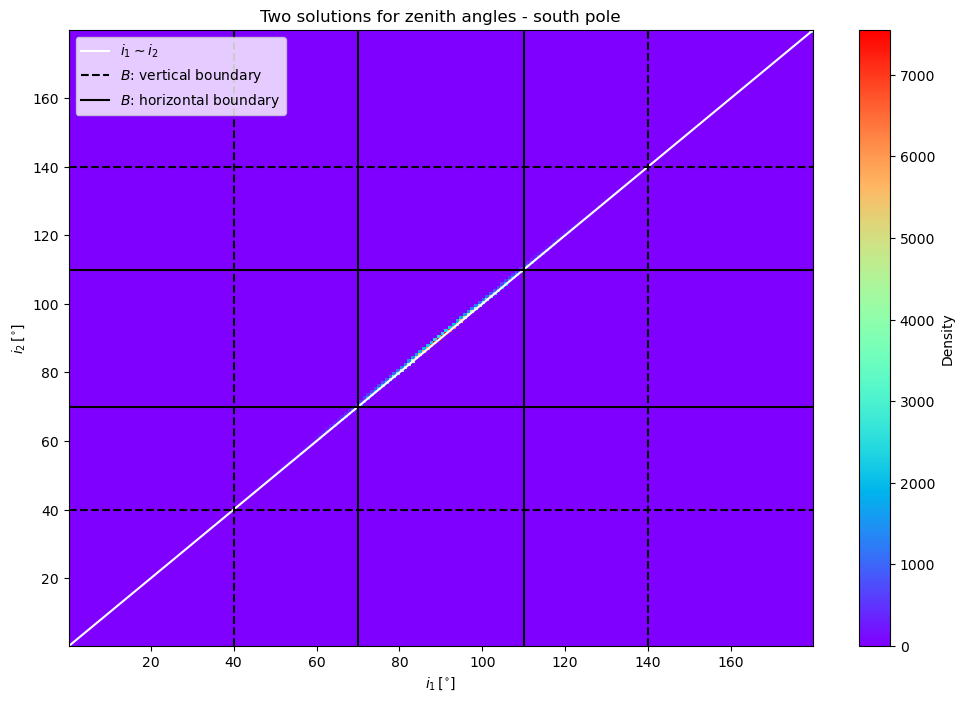

In [135]:
plt.figure(figsize=(12, 8))

hist, xedges, yedges, img = plt.hist2d(i1.flatten(), i2.flatten(), bins=200, cmap='rainbow')
cb = plt.colorbar(img)
cb.set_label('Density')

plt.xlabel(r'$i_1\,[^{\circ}]$')
plt.ylabel(r'$i_2\,[^{\circ}]$')

plt.plot([0, 180], [0, 180], color='white', linestyle='-', label=r'$i_1\sim i_2$')

plt.axvline(40, color='black', linestyle='--', label='$B$: vertical boundary')
plt.axvline(140, color='black', linestyle='--')
plt.axhline(40, color='black', linestyle='--')
plt.axhline(140, color='black', linestyle='--')

plt.axvline(70, color='black', linestyle='-', label='$B$: horizontal boundary')
plt.axvline(110, color='black', linestyle='-')
plt.axhline(70, color='black', linestyle='-')
plt.axhline(110, color='black', linestyle='-')

plt.title('Two solutions for zenith angles - south pole')
plt.legend()
plt.grid(False)
plt.show()

### Since we've determined zenith angles, we proceed to examine components of 
### the magnetic field. We have certain classification to do.

In [136]:
# Initialization of components of magnetic field vector
Bz = np.zeros_like(B)
Bx = np.zeros_like(B)
By = np.zeros_like(B)

# Classification based on zenith angles i1
vertical_mask = (i1 <= 40) | (i1 >= 140) 
horizontal_mask = (i1 >= 70) & (i1 <= 110) 
undetermined_mask = ~vertical_mask & ~horizontal_mask

# Vertical field 
Bz[vertical_mask] = B[vertical_mask]  
Bz[horizontal_mask | undetermined_mask] = 0  

# Horizontal field 
Bx[horizontal_mask] = B[horizontal_mask] * np.cos(chi[horizontal_mask])  
By[horizontal_mask] = B[horizontal_mask] * np.sin(chi[horizontal_mask]) 

# Undetermined fields
Bx[vertical_mask | undetermined_mask] = 0
By[vertical_mask | undetermined_mask] = 0

### Finaly, we can plot the results.

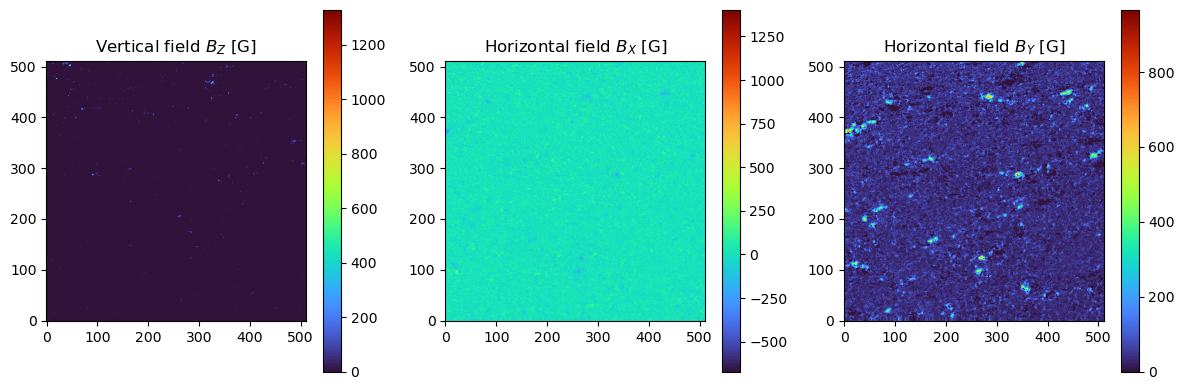

In [138]:
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.imshow(Bz, cmap='turbo', origin='lower')
plt.colorbar()
plt.title(r'Vertical field $B_Z$ [G]')

plt.subplot(132)
plt.imshow(Bx, cmap='turbo', origin='lower')
plt.colorbar()
plt.title(r'Horizontal field $B_X$ [G]')

plt.subplot(133)
plt.imshow(By, cmap='turbo', origin='lower')
plt.colorbar()
plt.title('Horizontal field $B_Y$ [G]')

plt.tight_layout()
plt.show()

### We can look at the horizontal field, without it's components.

In [139]:
# Horizontal field 
Bh = np.zeros_like(B)
Bh[horizontal_mask] = B[horizontal_mask]

# Undetermined fields
Bh[vertical_mask | undetermined_mask] = 0

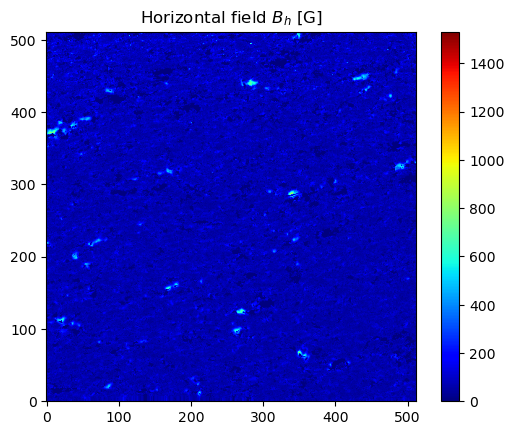

In [140]:
plt.imshow(Bh, cmap='jet', origin='lower')
plt.colorbar()
plt.title('Horizontal field $B_h$ [G]')
plt.show()

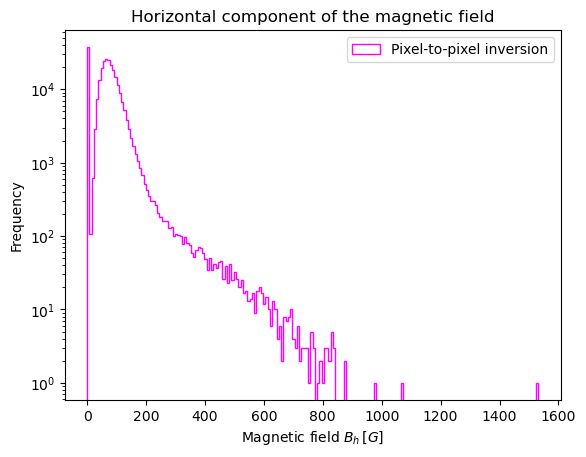

In [141]:
num_bins = 200 

plt.hist(Bh.ravel(), bins=num_bins, color='magenta',
         label='Pixel-to-pixel inversion', histtype='step')

plt.title(r'Horizontal component of the magnetic field')
plt.xlabel(r'Magnetic field $B_h\,[G]$')
plt.ylabel(r'Frequency')

# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))

plt.legend()
plt.grid(False)
plt.show()

### We inspect the results further via histograms.

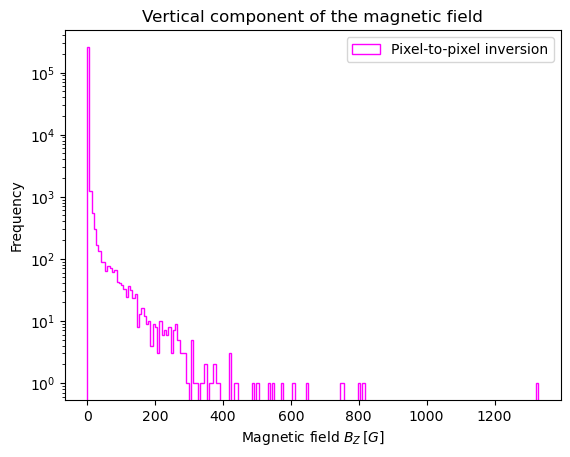

In [142]:
num_bins = 200 

plt.hist(Bz.ravel(), bins=num_bins, color='magenta',
         label='Pixel-to-pixel inversion', histtype='step')

plt.title(r'Vertical component of the magnetic field')
plt.xlabel(r'Magnetic field $B_Z\,[G]$')
plt.ylabel(r'Frequency')

# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))

plt.legend()
plt.grid(False)
plt.show()

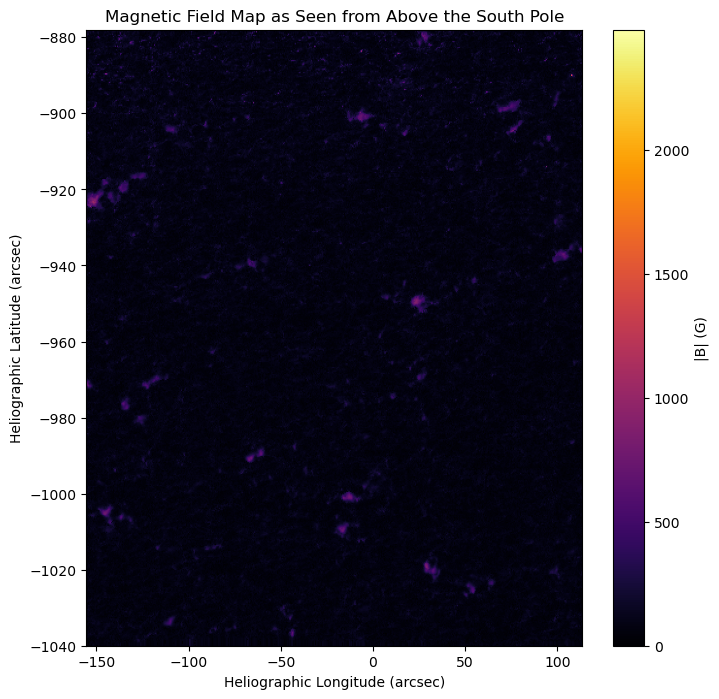

In [143]:
# Field of view (arcseconds)
FOVX = 269  # arcsec/pixel in x
FOVY = 162   # arcsec/pixel in y
arcsec_per_pixel_x = FOVX / B.shape[1]
arcsec_per_pixel_y = FOVY / B.shape[0]

# Heliographic center of the FOV (given)
XCEN = 4.64630                                              
YCEN    =              912.331 /

# Create the x and y coordinates of the pixels (arcseconds)
x_coords = np.linspace(XCEN - FOVX / 2, XCEN + FOVX / 2, B.shape[1])
y_coords = np.linspace(YCEN - FOVY / 2, YCEN + FOVY / 2, B.shape[0])

# Meshgrid of pixel coordinates
X, Y = np.meshgrid(x_coords, y_coords)

# Foreshortening factor for pixels near the south pole
foreshortening_factor = np.cos(np.radians(Y / 3600))  # Simplified, assuming small patch

# Apply foreshortening to magnetic field data
B_corrected = B * foreshortening_factor

# Plot the corrected magnetic field with a colorbar
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(B_corrected, extent=(XCEN - FOVX / 2, XCEN + FOVX / 2, YCEN - FOVY / 2, YCEN + FOVY / 2),
               cmap='inferno', origin='lower', aspect='auto')

# Add colorbar for the magnetic field strength
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('|B| (G)')

# Add circular arcs for latitude every 5 degrees
latitudes = np.arange(0, 90, 5)  # Latitude lines from 0 to 90 degrees
arcsec_per_degree = 3600  # Arcseconds per degree

for lat in latitudes:
    radius = lat * arcsec_per_degree  # Convert latitude to arcseconds
    circle = plt.Circle((XCEN, YCEN), radius, color='white', fill=False, linestyle='-', lw=1)
    ax.add_artist(circle)

# Add labels and title
ax.set_title('Magnetic Field Map as Seen from Above the South Pole')
ax.set_xlabel('Heliographic Longitude (arcsec)')
ax.set_ylabel('Heliographic Latitude (arcsec)')

plt.show()
